In [7]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
import os.path as path

In [20]:
data_path = 'data/'

In [ ]:
train_df = pd.read_parquet(path.join(data_path, "train_data.pqt"))
test_df = pd.read_parquet(path.join(data_path, "test_data.pqt"))

In [45]:
train_df

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
0,0,month_1,0.744845,0.705492,1.287207,0.748101,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.951166,0.568681,0.897565,0.553624,0.774354,0.936506,0.295984,0.967947,"{α, γ}",{other}
1,0,month_2,1.049605,0.831916,2.458609,1.053805,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.948812,0.499716,0.785029,0.551904,0.696576,0.990157,0.298873,0.945969,"{α, γ}",{other}
2,0,month_3,0.692653,0.740253,0.430042,0.695747,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.946458,0.442244,0.877050,0.551044,0.663243,0.810065,0.294829,0.956958,"{α, γ}",{other}
3,1,month_1,-0.081586,-0.091860,-0.114040,-0.080890,channel_code_2,city_14,city_type_0,None,...,0.945281,0.407762,0.369318,0.567093,0.785465,-0.184002,0.253523,0.462452,{other},{other}
4,1,month_2,-0.094962,-0.100504,-0.119302,-0.094307,channel_code_2,city_14,city_type_0,None,...,0.946066,0.430750,0.067275,0.559928,0.696576,-0.183854,0.255545,0.495419,{other},{other}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,199998,month_2,-0.156775,-0.204960,-0.125987,-0.156311,channel_code_9,city_14,city_type_0,None,...,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{},{}
599996,199998,month_3,-0.156776,-0.204960,-0.125995,-0.156312,channel_code_9,city_14,city_type_0,None,...,0.944497,0.384773,-0.165588,0.546889,0.407687,-0.201123,0.250924,0.374540,{α},{}
599997,199999,month_1,-0.156712,-0.204913,-0.125831,-0.156248,channel_code_14,city_1876,city_type_0,index_city_code_195,...,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{},{}
599998,199999,month_2,-0.156712,-0.204913,-0.125831,-0.156248,channel_code_14,city_1876,city_type_0,index_city_code_195,...,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{},{}


In [46]:
cat_cols = [
    "channel_code", "city", "city_type",
    "okved", "segment", "start_cluster",
    "index_city_code", "ogrn_month", "ogrn_year",
]

In [47]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

cluster_weights = pd.read_excel(path.join(data_path, 'cluster_weights.xlsx')).set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

In [48]:
sample_submission_df = pd.read_csv(path.join(data_path, 'sample_submission.csv'))

Заполняем нулями числовые фичи, а категориальные меткой Unknown

In [49]:
train_df[cat_cols] = train_df[cat_cols].fillna('Unknown')
test_df[cat_cols] = test_df[cat_cols].fillna('Unknown')
train_not_nan = train_df.fillna(0, inplace=False)
test_not_nan = test_df.fillna(0, inplace=False)

In [50]:
train_not_nan[cat_cols] = train_not_nan[cat_cols].astype("str")
test_not_nan[cat_cols] = test_not_nan[cat_cols].astype("str")

In [51]:
train_df.isna().sum()

id                              0
date                            0
balance_amt_avg             65577
balance_amt_max             65577
balance_amt_min             65577
                            ...  
sum_cred_h_oper_3m              0
cnt_cred_h_oper_3m         165252
cnt_days_cred_h_oper_3m    165252
start_cluster                   0
end_cluster                     0
Length: 93, dtype: int64

In [52]:
train_not_nan.isna().sum().sum()

0

Кетбуст для предикта start_cluster в 6 месяце

In [53]:
test_not_nan_and_unknown=test_not_nan[test_not_nan.start_cluster!='Unknown']
test_not_nan_and_unknown

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster
0,200000,month_4,-0.096224,0.335496,-0.125995,-0.095578,channel_code_12,city_14,city_type_0,Unknown,...,0.010952,0.946066,0.407762,-0.153950,0.548895,0.541020,0.031742,0.257278,0.561353,{α}
1,200000,month_5,-0.024255,-0.059806,-0.124295,-0.023381,channel_code_12,city_14,city_type_0,Unknown,...,0.006812,0.945281,0.396267,-0.150505,0.549468,0.552131,0.237817,0.264211,0.715199,{α}
3,200001,month_4,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,Unknown,...,-0.028584,0.000000,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{α}
4,200001,month_5,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,Unknown,...,-0.028584,0.000000,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{α}
6,200002,month_4,-0.096506,0.185905,-0.125995,-0.095856,channel_code_12,city_14,city_type_0,index_city_code_78,...,0.510730,0.950774,0.545693,0.715525,0.554913,0.718798,0.445811,0.254968,0.495419,{other}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290112,299997,month_4,-0.125643,-0.098937,-0.124644,-0.125084,channel_code_17,city_85,city_type_0,index_city_code_103,...,-0.028584,0.944497,0.384773,0.048962,0.551331,0.652131,0.016130,0.256412,0.550364,{α}
290113,299997,month_5,-0.121206,-0.148644,-0.121388,-0.120632,channel_code_17,city_85,city_type_0,index_city_code_103,...,-0.028584,0.944497,0.384773,0.083778,0.552047,0.685465,0.070113,0.258723,0.616298,{α}
290115,299998,month_5,0.000000,0.000000,0.000000,0.000000,Unknown,Unknown,Unknown,Unknown,...,-0.028584,0.000000,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{}
290117,299999,month_4,-0.145899,-0.173298,-0.125995,-0.145402,channel_code_9,city_6,city_type_0,index_city_code_34,...,-0.028584,0.944497,0.384773,-0.097640,0.550901,0.574354,-0.101369,0.252657,0.440474,{α}


In [54]:
train_not_nan_and_end=train_not_nan.drop(columns=['end_cluster'])
train_not_nan_and_end

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster
0,0,month_1,0.744845,0.705492,1.287207,0.748101,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.186820,0.951166,0.568681,0.897565,0.553624,0.774354,0.936506,0.295984,0.967947,"{α, γ}"
1,0,month_2,1.049605,0.831916,2.458609,1.053805,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.125043,0.948812,0.499716,0.785029,0.551904,0.696576,0.990157,0.298873,0.945969,"{α, γ}"
2,0,month_3,0.692653,0.740253,0.430042,0.695747,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.033607,0.946458,0.442244,0.877050,0.551044,0.663243,0.810065,0.294829,0.956958,"{α, γ}"
3,1,month_1,-0.081586,-0.091860,-0.114040,-0.080890,channel_code_2,city_14,city_type_0,Unknown,...,-0.024561,0.945281,0.407762,0.369318,0.567093,0.785465,-0.184002,0.253523,0.462452,{other}
4,1,month_2,-0.094962,-0.100504,-0.119302,-0.094307,channel_code_2,city_14,city_type_0,Unknown,...,-0.023981,0.946066,0.430750,0.067275,0.559928,0.696576,-0.183854,0.255545,0.495419,{other}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,199998,month_2,-0.156775,-0.204960,-0.125987,-0.156311,channel_code_9,city_14,city_type_0,Unknown,...,-0.028584,0.000000,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{}
599996,199998,month_3,-0.156776,-0.204960,-0.125995,-0.156312,channel_code_9,city_14,city_type_0,Unknown,...,-0.028584,0.944497,0.384773,-0.165588,0.546889,0.407687,-0.201123,0.250924,0.374540,{α}
599997,199999,month_1,-0.156712,-0.204913,-0.125831,-0.156248,channel_code_14,city_1876,city_type_0,index_city_code_195,...,-0.028584,0.000000,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{}
599998,199999,month_2,-0.156712,-0.204913,-0.125831,-0.156248,channel_code_14,city_1876,city_type_0,index_city_code_195,...,-0.028584,0.000000,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{}


Нужно учитывать {} 
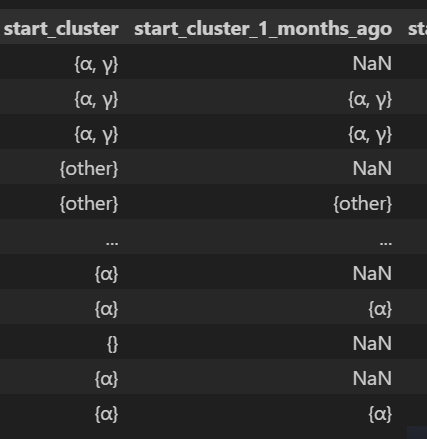

In [55]:
sample = pd.concat([train_not_nan_and_end, test_not_nan_and_unknown])

In [56]:
train_not_nan['start_cluster_1_months_ago'] = train_not_nan.groupby('id')['start_cluster'].shift(periods=1)
train_not_nan['start_cluster_2_months_ago'] = train_not_nan.groupby('id')['start_cluster'].shift(periods=2)
train_not_nan.fillna(0)

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster,start_cluster_1_months_ago,start_cluster_2_months_ago
0,0,month_1,0.744845,0.705492,1.287207,0.748101,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.897565,0.553624,0.774354,0.936506,0.295984,0.967947,"{α, γ}",{other},0,0
1,0,month_2,1.049605,0.831916,2.458609,1.053805,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.785029,0.551904,0.696576,0.990157,0.298873,0.945969,"{α, γ}",{other},"{α, γ}",0
2,0,month_3,0.692653,0.740253,0.430042,0.695747,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.877050,0.551044,0.663243,0.810065,0.294829,0.956958,"{α, γ}",{other},"{α, γ}","{α, γ}"
3,1,month_1,-0.081586,-0.091860,-0.114040,-0.080890,channel_code_2,city_14,city_type_0,Unknown,...,0.369318,0.567093,0.785465,-0.184002,0.253523,0.462452,{other},{other},0,0
4,1,month_2,-0.094962,-0.100504,-0.119302,-0.094307,channel_code_2,city_14,city_type_0,Unknown,...,0.067275,0.559928,0.696576,-0.183854,0.255545,0.495419,{other},{other},{other},0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,199998,month_2,-0.156775,-0.204960,-0.125987,-0.156311,channel_code_9,city_14,city_type_0,Unknown,...,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{},{},{},0
599996,199998,month_3,-0.156776,-0.204960,-0.125995,-0.156312,channel_code_9,city_14,city_type_0,Unknown,...,-0.165588,0.546889,0.407687,-0.201123,0.250924,0.374540,{α},{},{},{}
599997,199999,month_1,-0.156712,-0.204913,-0.125831,-0.156248,channel_code_14,city_1876,city_type_0,index_city_code_195,...,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{},{},0,0
599998,199999,month_2,-0.156712,-0.204913,-0.125831,-0.156248,channel_code_14,city_1876,city_type_0,index_city_code_195,...,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{},{},{},0


In [57]:
sample['start_cluster_1_months_ago'] = sample.groupby('id')['start_cluster'].shift(periods=1, fill_value=0)
sample['start_cluster_2_months_ago'] = sample.groupby('id')['start_cluster'].shift(periods=2, fill_value=0)

In [58]:
sample

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,start_cluster_1_months_ago,start_cluster_2_months_ago
0,0,month_1,0.744845,0.705492,1.287207,0.748101,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.568681,0.897565,0.553624,0.774354,0.936506,0.295984,0.967947,"{α, γ}",0,0
1,0,month_2,1.049605,0.831916,2.458609,1.053805,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.499716,0.785029,0.551904,0.696576,0.990157,0.298873,0.945969,"{α, γ}","{α, γ}",0
2,0,month_3,0.692653,0.740253,0.430042,0.695747,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.442244,0.877050,0.551044,0.663243,0.810065,0.294829,0.956958,"{α, γ}","{α, γ}","{α, γ}"
3,1,month_1,-0.081586,-0.091860,-0.114040,-0.080890,channel_code_2,city_14,city_type_0,Unknown,...,0.407762,0.369318,0.567093,0.785465,-0.184002,0.253523,0.462452,{other},0,0
4,1,month_2,-0.094962,-0.100504,-0.119302,-0.094307,channel_code_2,city_14,city_type_0,Unknown,...,0.430750,0.067275,0.559928,0.696576,-0.183854,0.255545,0.495419,{other},{other},0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290112,299997,month_4,-0.125643,-0.098937,-0.124644,-0.125084,channel_code_17,city_85,city_type_0,index_city_code_103,...,0.384773,0.048962,0.551331,0.652131,0.016130,0.256412,0.550364,{α},0,0
290113,299997,month_5,-0.121206,-0.148644,-0.121388,-0.120632,channel_code_17,city_85,city_type_0,index_city_code_103,...,0.384773,0.083778,0.552047,0.685465,0.070113,0.258723,0.616298,{α},{α},0
290115,299998,month_5,0.000000,0.000000,0.000000,0.000000,Unknown,Unknown,Unknown,Unknown,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{},0,0
290117,299999,month_4,-0.145899,-0.173298,-0.125995,-0.145402,channel_code_9,city_6,city_type_0,index_city_code_34,...,0.384773,-0.097640,0.550901,0.574354,-0.101369,0.252657,0.440474,{α},0,0


In [59]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [60]:
cat_cols_model1 =[
    "channel_code", "city", "city_type",
    "okved", "segment", "start_cluster",
    "index_city_code", "ogrn_month", "ogrn_year",
    'start_cluster_1_months_ago', 'start_cluster_2_months_ago',
]

In [61]:
sample

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,start_cluster_1_months_ago,start_cluster_2_months_ago
0,0,month_1,0.744845,0.705492,1.287207,0.748101,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.568681,0.897565,0.553624,0.774354,0.936506,0.295984,0.967947,"{α, γ}",0,0
1,0,month_2,1.049605,0.831916,2.458609,1.053805,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.499716,0.785029,0.551904,0.696576,0.990157,0.298873,0.945969,"{α, γ}","{α, γ}",0
2,0,month_3,0.692653,0.740253,0.430042,0.695747,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.442244,0.877050,0.551044,0.663243,0.810065,0.294829,0.956958,"{α, γ}","{α, γ}","{α, γ}"
3,1,month_1,-0.081586,-0.091860,-0.114040,-0.080890,channel_code_2,city_14,city_type_0,Unknown,...,0.407762,0.369318,0.567093,0.785465,-0.184002,0.253523,0.462452,{other},0,0
4,1,month_2,-0.094962,-0.100504,-0.119302,-0.094307,channel_code_2,city_14,city_type_0,Unknown,...,0.430750,0.067275,0.559928,0.696576,-0.183854,0.255545,0.495419,{other},{other},0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290112,299997,month_4,-0.125643,-0.098937,-0.124644,-0.125084,channel_code_17,city_85,city_type_0,index_city_code_103,...,0.384773,0.048962,0.551331,0.652131,0.016130,0.256412,0.550364,{α},0,0
290113,299997,month_5,-0.121206,-0.148644,-0.121388,-0.120632,channel_code_17,city_85,city_type_0,index_city_code_103,...,0.384773,0.083778,0.552047,0.685465,0.070113,0.258723,0.616298,{α},{α},0
290115,299998,month_5,0.000000,0.000000,0.000000,0.000000,Unknown,Unknown,Unknown,Unknown,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{},0,0
290117,299999,month_4,-0.145899,-0.173298,-0.125995,-0.145402,channel_code_9,city_6,city_type_0,index_city_code_34,...,0.384773,-0.097640,0.550901,0.574354,-0.101369,0.252657,0.440474,{α},0,0


In [62]:


cat_cols_model1 =[
    "channel_code", "city", "city_type",
    "okved", "segment",
    "index_city_code", "ogrn_month", "ogrn_year",
    'start_cluster_1_months_ago', 'start_cluster_2_months_ago',
]


scores = []

models_to_fill_start_cluster = []


strat_kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
max_score = 0
for train_index, test_index in strat_kfold.split(sample, sample['start_cluster']):

    train = sample.iloc[train_index]
    test = sample.iloc[test_index]

    X_train, X_test, y_train, y_test = train.drop('start_cluster', axis=1), test.drop('start_cluster', axis=1), \
                                        train['start_cluster'], test['start_cluster']
    

    model = CatBoostClassifier(
        iterations = 1000,
        depth=4,
        learning_rate=0.03,
        cat_features = cat_cols_model1,
        early_stopping_rounds=100,
        loss_function='MultiClass',
        task_type="GPU", 
        random_seed=42
    )

    train_pool = Pool(
        data=X_train.drop(["id", "date"], axis=1),
        label=y_train,
        cat_features=cat_cols_model1
    )
    test_pool = Pool(
        data=X_test.drop(["id", "date"], axis=1), 
        label=y_test,
        cat_features=cat_cols_model1
    )

    model.fit(train_pool, eval_set=(test_pool), verbose=333)
    models_to_fill_start_cluster.append(model)

    y_pred_proba = model.predict_proba(X_test.drop(["id", "date"], axis=1))
    scores.append(weighted_roc_auc(y_test, y_pred_proba, model.classes_, weights_dict))
    score=weighted_roc_auc(y_test, y_pred_proba, model.classes_, weights_dict)
    print(score)
    if score > max_score:
        max_score = score
        best_model_start_cluster = model

print(np.mean(score))

0:	learn: 2.5364166	test: 2.5364740	best: 2.5364740 (0)	total: 190ms	remaining: 3m 9s
333:	learn: 0.4328539	test: 0.4314410	best: 0.4314410 (333)	total: 24.2s	remaining: 48.2s
666:	learn: 0.4013499	test: 0.4017501	best: 0.4017501 (666)	total: 48.1s	remaining: 24s
999:	learn: 0.3864008	test: 0.3885098	best: 0.3885098 (999)	total: 1m 11s	remaining: 0us
bestTest = 0.3885098104
bestIteration = 999
0.9712873429253926
0:	learn: 2.5429558	test: 2.5433813	best: 2.5433813 (0)	total: 160ms	remaining: 2m 39s
333:	learn: 0.4336661	test: 0.4353452	best: 0.4353452 (333)	total: 23.4s	remaining: 46.7s
666:	learn: 0.4011890	test: 0.4037342	best: 0.4037342 (666)	total: 47.5s	remaining: 23.7s
999:	learn: 0.3857521	test: 0.3894044	best: 0.3894044 (999)	total: 1m 10s	remaining: 0us
bestTest = 0.3894043618
bestIteration = 999
0.9749171448328228
0:	learn: 2.5364439	test: 2.5365839	best: 2.5365839 (0)	total: 195ms	remaining: 3m 15s
333:	learn: 0.4325918	test: 0.4321820	best: 0.4321820 (333)	total: 23.4s	remai

In [63]:
feature_names = sample.drop(["id", "date", 'start_cluster'], axis=1).columns.tolist()
feature_importance = best_model_start_cluster.get_feature_importance()
importance = pd.DataFrame({'name': feature_names, 'importance': feature_importance})

dtype_list = []
for feature_name in feature_names:
    dtype = sample[feature_name].dtype
    dtype_list.append(dtype)

importance['dtype'] = dtype_list

imp_df_sorted = importance.sort_values(by='importance', ascending=False)
top_n = 30  
top_n_imp_df = imp_df_sorted.head(top_n)
top_n_imp_df

,name,importance,dtype
89,start_cluster_1_months_ago,22.044788,object
56,cnt_a_oper_3m,13.204535,float64
69,cnt_cred_e_oper_3m,6.196921,float64
17,segment,4.365521,object
2,balance_amt_min,3.876408,float64
68,sum_cred_e_oper_3m,3.716139,float64
16,okved,2.987500,object
1,balance_amt_max,2.751872,float64
12,ft_registration_date,2.317093,float64
66,cnt_deb_e_oper_3m,2.292876,float64


In [64]:
imp_df_sorted.head(30)

,name,importance,dtype
89,start_cluster_1_months_ago,22.044788,object
56,cnt_a_oper_3m,13.204535,float64
69,cnt_cred_e_oper_3m,6.196921,float64
17,segment,4.365521,object
2,balance_amt_min,3.876408,float64
68,sum_cred_e_oper_3m,3.716139,float64
16,okved,2.987500,object
1,balance_amt_max,2.751872,float64
12,ft_registration_date,2.317093,float64
66,cnt_deb_e_oper_3m,2.292876,float64


In [65]:
train_not_nan = train_not_nan.fillna(0, inplace=False)

In [66]:
train_not_nan

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster,start_cluster_1_months_ago,start_cluster_2_months_ago
0,0,month_1,0.744845,0.705492,1.287207,0.748101,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.897565,0.553624,0.774354,0.936506,0.295984,0.967947,"{α, γ}",{other},0,0
1,0,month_2,1.049605,0.831916,2.458609,1.053805,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.785029,0.551904,0.696576,0.990157,0.298873,0.945969,"{α, γ}",{other},"{α, γ}",0
2,0,month_3,0.692653,0.740253,0.430042,0.695747,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.877050,0.551044,0.663243,0.810065,0.294829,0.956958,"{α, γ}",{other},"{α, γ}","{α, γ}"
3,1,month_1,-0.081586,-0.091860,-0.114040,-0.080890,channel_code_2,city_14,city_type_0,Unknown,...,0.369318,0.567093,0.785465,-0.184002,0.253523,0.462452,{other},{other},0,0
4,1,month_2,-0.094962,-0.100504,-0.119302,-0.094307,channel_code_2,city_14,city_type_0,Unknown,...,0.067275,0.559928,0.696576,-0.183854,0.255545,0.495419,{other},{other},{other},0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,199998,month_2,-0.156775,-0.204960,-0.125987,-0.156311,channel_code_9,city_14,city_type_0,Unknown,...,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{},{},{},0
599996,199998,month_3,-0.156776,-0.204960,-0.125995,-0.156312,channel_code_9,city_14,city_type_0,Unknown,...,-0.165588,0.546889,0.407687,-0.201123,0.250924,0.374540,{α},{},{},{}
599997,199999,month_1,-0.156712,-0.204913,-0.125831,-0.156248,channel_code_14,city_1876,city_type_0,index_city_code_195,...,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{},{},0,0
599998,199999,month_2,-0.156712,-0.204913,-0.125831,-0.156248,channel_code_14,city_1876,city_type_0,index_city_code_195,...,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{},{},{},0


In [67]:

cat_columns = ["channel_code", "city", "city_type", "okved", "segment", "start_cluster",
            "index_city_code", "ogrn_month", "ogrn_year",'start_cluster_1_months_ago','start_cluster_2_months_ago']

#Добавляем фичи также как в start_cluster_1_months_ago start_cluster_2_months_ago со сдвигом
features_shift = [    'segment', 'okved', 'index_city_code', 'balance_amt_max', 'balance_amt_min','cnt_cred_e_oper_1m',
                      'sum_cred_e_oper_1m','cnt_days_deb_e_oper_3m',
                      'cnt_c_oper_1m', 'sum_of_paym_1y', 'ft_registration_date',
                      'cnt_deb_e_oper_1m', 'sum_deb_e_oper_3m', 'balance_amt_avg',
                      'cnt_days_cred_e_oper_1m', 'sum_cred_e_oper_3m', 'min_founderpres',
                      'ogrn_year', 'channel_code', 'city', 'sum_of_paym_2m', 'balance_amt_day_avg', 'sum_deb_h_oper_1m',
                      
                 ]
features_shift_in_cat_columns = [
                                    "channel_code", "city", "okved", "segment","index_city_code", 
                                    "ogrn_year",
                                ]

In [68]:
dop_cat_columns = []

for col in features_shift_in_cat_columns:
    dop_cat_columns.append(col+'_1')
    dop_cat_columns.append(col+'_2')

for col in features_shift:
    train_not_nan[col+'_1'] = train_not_nan.groupby('id')[col].shift(1)
    train_not_nan[col+'_2'] = train_not_nan.groupby('id')[col].shift(2)
train_not_nan.fillna(0, inplace=True)

<span style="font-size:24pt;">Перемножения топ 20 фичей между собой и добавляем их как фичи</span>

In [ ]:

'''Топ 30 фичей float
56	cnt_a_oper_3m	12.586634	float64
69	cnt_cred_e_oper_3m	5.371826	float64
62	cnt_deb_d_oper_3m	3.744791	float64
65	sum_deb_e_oper_3m	3.739166	float64
2	balance_amt_min	3.550908	float64
68	sum_cred_e_oper_3m	3.133741	float64
1	balance_amt_max	3.079231	float64
16	okved	2.801770	object
58	cnt_b_oper_3m	2.619616	float64
20	sum_of_paym_1y	2.184808	float64
12	ft_registration_date	2.182904	float64
66	cnt_deb_e_oper_3m	1.807636	float64
5	city	1.631529	object
36	cnt_days_cred_e_oper_1m	1.535107	float64
3	balance_amt_day_avg	1.320321	float64
57	sum_b_oper_3m	1.279499	float64
86	sum_cred_h_oper_3m	1.196033	float64
0	balance_amt_avg	1.136300	float64
32	cnt_deb_e_oper_1m	1.095511	float64
70	cnt_days_cred_e_oper_3m	0.947641	float64
67	cnt_days_deb_e_oper_3m	0.912024	float64
73	cnt_days_deb_f_oper_3m	0.865418	float64
35	cnt_cred_e_oper_1m	0.796520	float64
61	sum_deb_d_oper_3m	0.771266	float64
31	sum_deb_e_oper_1m	0.723868	float64
'''
features_for_multiplication = [
                      'cnt_a_oper_3m','cnt_cred_e_oper_3m','cnt_b_oper_3m','cnt_deb_d_oper_3m','cnt_cred_e_oper_1m',

                      'balance_amt_avg',
                      'balance_amt_min','sum_deb_e_oper_3m','balance_amt_max','sum_cred_e_oper_3m',
                      'ft_registration_date','sum_of_paym_1y','cnt_days_cred_e_oper_1m','cnt_deb_e_oper_1m',
                      'balance_amt_day_avg','cnt_days_deb_e_oper_3m',
                      'sum_of_paym_2m','cnt_days_cred_e_oper_3m','cnt_deb_e_oper_3m']

for i in features_for_multiplication:
    for j in features_for_multiplication:
        if i != j:
            train_not_nan[i+'_multiplication_'+j] = train_not_nan[i] * train_not_nan[j]
train_not_nan.fillna(0, inplace=True)

In [70]:
train_not_nan.isna().sum().sum()

0

Трейн с доп фичами

In [71]:
train_not_nan

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_deb_e_oper_3m_multiplication_balance_amt_max,cnt_deb_e_oper_3m_multiplication_sum_cred_e_oper_3m,cnt_deb_e_oper_3m_multiplication_ft_registration_date,cnt_deb_e_oper_3m_multiplication_sum_of_paym_1y,cnt_deb_e_oper_3m_multiplication_cnt_days_cred_e_oper_1m,cnt_deb_e_oper_3m_multiplication_cnt_deb_e_oper_1m,cnt_deb_e_oper_3m_multiplication_balance_amt_day_avg,cnt_deb_e_oper_3m_multiplication_cnt_days_deb_e_oper_3m,cnt_deb_e_oper_3m_multiplication_sum_of_paym_2m,cnt_deb_e_oper_3m_multiplication_cnt_days_cred_e_oper_3m
0,0,month_1,0.744845,0.705492,1.287207,0.748101,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.300564,0.185744,1.044713,0.217912,0.265537,0.380475,0.318716,0.511897,0.401441,0.541283
1,0,month_2,1.049605,0.831916,2.458609,1.053805,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.354390,0.175171,1.052168,0.207214,0.224287,0.380430,0.448914,0.483761,0.275066,0.527188
2,0,month_3,0.692653,0.740253,0.430042,0.695747,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.315335,0.119535,1.058967,0.204705,0.265506,0.380424,0.296377,0.479068,0.171928,0.522494
3,1,month_1,-0.081586,-0.091860,-0.114040,-0.080890,channel_code_2,city_14,city_type_0,Unknown,...,-0.039184,0.083190,0.074237,0.022199,0.307148,0.381057,-0.034505,0.568784,0.005994,0.574769
4,1,month_2,-0.094962,-0.100504,-0.119302,-0.094307,channel_code_2,city_14,city_type_0,Unknown,...,-0.042847,0.025375,0.081756,0.014305,0.238213,0.380805,-0.040205,0.535669,-0.024553,0.546335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,199998,month_2,-0.156775,-0.204960,-0.125987,-0.156311,channel_code_9,city_14,city_type_0,Unknown,...,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000
599996,199998,month_3,-0.156776,-0.204960,-0.125995,-0.156312,channel_code_9,city_14,city_type_0,Unknown,...,-0.087257,-0.066638,-0.148525,0.000000,0.004417,0.380116,-0.066546,0.315038,0.000000,0.274228
599997,199999,month_1,-0.156712,-0.204913,-0.125831,-0.156248,channel_code_14,city_1876,city_type_0,index_city_code_195,...,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000
599998,199999,month_2,-0.156712,-0.204913,-0.125831,-0.156248,channel_code_14,city_1876,city_type_0,index_city_code_195,...,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000


In [72]:
dop_cat_columns

['channel_code_1',
 'channel_code_2',
 'city_1',
 'city_2',
 'okved_1',
 'okved_2',
 'segment_1',
 'segment_2',
 'index_city_code_1',
 'index_city_code_2',
 'ogrn_year_1',
 'ogrn_year_2']

In [75]:
train_not_nan['start_cluster_1_months_ago']

0               0
1          {α, γ}
2          {α, γ}
3               0
4         {other}
           ...   
599995         {}
599996         {}
599997          0
599998         {}
599999         {}
Name: start_cluster_1_months_ago, Length: 600000, dtype: object

In [76]:

cat_cols_model2 = cat_cols +['start_cluster_1_months_ago','start_cluster_2_months_ago']+ dop_cat_columns

strat_kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
models2 = []

max_score_for_endmodel = 0
for train_index, test_index in strat_kfold.split(train_not_nan,train_not_nan['end_cluster']):

    train = train_not_nan.iloc[train_index]
    test = train_not_nan.iloc[test_index]

    X_train, X_test, y_train, y_test = train.drop('end_cluster', axis=1), test.drop('end_cluster', axis=1), \
                                        train['end_cluster'], test['end_cluster']
    

    model = CatBoostClassifier(
        iterations = 2000,
        depth=7,
        learning_rate=0.0265,
        cat_features = cat_cols_model2,
        early_stopping_rounds=100,
        loss_function='MultiClass',
        task_type="GPU",
        random_seed=42
    )

    train_pool = Pool(
        data=X_train.drop(["id", "date"],axis=1),
        label=y_train,
        cat_features=cat_cols_model2
    )
    test_pool = Pool(
        data=X_test.drop(["id", "date"],axis=1), 
        label=y_test,
        cat_features=cat_cols_model2
    )

    model.fit(train_pool, eval_set=(test_pool), verbose=333)
    models2.append(model)

    y_pred_proba = model.predict_proba(X_test.drop(["id", "date"],axis=1))
    score_end_model=weighted_roc_auc(y_test, y_pred_proba, model.classes_, weights_dict)
    print(score_end_model)

    if score_end_model > max_score_for_endmodel:
        max_score_for_endmodel = score_end_model
        best_model_end_cluster = model

print(np.mean(score_end_model))

0:	learn: 2.6152412	test: 2.6153731	best: 2.6153731 (0)	total: 388ms	remaining: 12m 54s
333:	learn: 0.8380829	test: 0.8446530	best: 0.8446530 (333)	total: 1m 4s	remaining: 5m 21s
666:	learn: 0.8105139	test: 0.8248055	best: 0.8248055 (666)	total: 2m 3s	remaining: 4m 7s
999:	learn: 0.7934696	test: 0.8151073	best: 0.8151073 (999)	total: 2m 59s	remaining: 2m 59s
1332:	learn: 0.7804912	test: 0.8085621	best: 0.8085621 (1332)	total: 3m 54s	remaining: 1m 57s
1665:	learn: 0.7692004	test: 0.8033915	best: 0.8033915 (1665)	total: 4m 48s	remaining: 57.8s
1998:	learn: 0.7592102	test: 0.7991927	best: 0.7991927 (1998)	total: 5m 41s	remaining: 171ms
1999:	learn: 0.7591743	test: 0.7991750	best: 0.7991750 (1999)	total: 5m 42s	remaining: 0us
bestTest = 0.799175
bestIteration = 1999
0.9291962427894864
0:	learn: 2.6157085	test: 2.6154831	best: 2.6154831 (0)	total: 325ms	remaining: 10m 50s
333:	learn: 0.8385574	test: 0.8434377	best: 0.8434377 (333)	total: 1m	remaining: 5m 1s
666:	learn: 0.8103288	test: 0.823

In [77]:
importance = pd.DataFrame({'name': X_train.drop(["id", "date"], axis=1).columns})

for i, model in enumerate(models2):
    feature_importance = model.get_feature_importance()
    importance[str(i)] = feature_importance

importance['total'] = importance.drop('name', axis=1).sum(axis=1)

top_features = importance[importance['total'] > 1.5]['name'].tolist()
importance = importance.sort_values('total', ascending=False)
top_30_features = importance.head(30)
top_50_features = importance.head(50)



In [78]:
len(top_30_features)
len(top_50_features)
top_50_features['name'].to_list()

['start_cluster',
 'okved',
 'index_city_code',
 'city',
 'segment',
 'channel_code',
 'min_founderpres',
 'ogrn_days_end_quarter',
 'max_founderpres',
 'ogrn_days_end_month',
 'ogrn_month',
 'balance_amt_min',
 'balance_amt_max',
 'cnt_days_cred_e_oper_1m_multiplication_cnt_days_deb_e_oper_3m',
 'sum_deb_g_oper_3m',
 'sum_deb_e_oper_3m_multiplication_sum_cred_e_oper_3m',
 'sum_deb_f_oper_3m',
 'sum_deb_h_oper_3m',
 'cnt_days_cred_e_oper_3m_multiplication_cnt_deb_e_oper_3m',
 'sum_cred_h_oper_3m',
 'start_cluster_1_months_ago',
 'balance_amt_avg_multiplication_balance_amt_day_avg',
 'ogrn_year',
 'sum_of_paym_1y',
 'ft_registration_date',
 'ogrn_exist_months',
 'sum_cred_e_oper_1m',
 'start_cluster_2_months_ago',
 'sum_of_paym_6m',
 'sum_deb_e_oper_3m_multiplication_ft_registration_date',
 'segment_1',
 'balance_amt_avg',
 'cnt_deb_h_oper_3m',
 'sum_cred_e_oper_3m_multiplication_sum_of_paym_1y',
 'city_type',
 'cnt_cred_h_oper_3m',
 'balance_amt_min_multiplication_ft_registration_date'

In [79]:
top_50_features['name'].to_list()

['start_cluster',
 'okved',
 'index_city_code',
 'city',
 'segment',
 'channel_code',
 'min_founderpres',
 'ogrn_days_end_quarter',
 'max_founderpres',
 'ogrn_days_end_month',
 'ogrn_month',
 'balance_amt_min',
 'balance_amt_max',
 'cnt_days_cred_e_oper_1m_multiplication_cnt_days_deb_e_oper_3m',
 'sum_deb_g_oper_3m',
 'sum_deb_e_oper_3m_multiplication_sum_cred_e_oper_3m',
 'sum_deb_f_oper_3m',
 'sum_deb_h_oper_3m',
 'cnt_days_cred_e_oper_3m_multiplication_cnt_deb_e_oper_3m',
 'sum_cred_h_oper_3m',
 'start_cluster_1_months_ago',
 'balance_amt_avg_multiplication_balance_amt_day_avg',
 'ogrn_year',
 'sum_of_paym_1y',
 'ft_registration_date',
 'ogrn_exist_months',
 'sum_cred_e_oper_1m',
 'start_cluster_2_months_ago',
 'sum_of_paym_6m',
 'sum_deb_e_oper_3m_multiplication_ft_registration_date',
 'segment_1',
 'balance_amt_avg',
 'cnt_deb_h_oper_3m',
 'sum_cred_e_oper_3m_multiplication_sum_of_paym_1y',
 'city_type',
 'cnt_cred_h_oper_3m',
 'balance_amt_min_multiplication_ft_registration_date'

In [80]:
train_not_nan[top_50_features['name'].to_list()]

,start_cluster,okved,index_city_code,city,segment,channel_code,min_founderpres,ogrn_days_end_quarter,max_founderpres,ogrn_days_end_month,...,balance_amt_min_multiplication_sum_deb_e_oper_3m,cnt_days_cred_e_oper_1m_multiplication_cnt_deb_e_oper_3m,sum_cred_e_oper_3m_multiplication_ft_registration_date,balance_amt_min_multiplication_sum_cred_e_oper_3m,cnt_days_cred_h_oper_3m,balance_amt_max_multiplication_sum_cred_e_oper_3m,balance_amt_day_avg,ft_registration_date_multiplication_sum_of_paym_1y,sum_deb_e_oper_3m_multiplication_balance_amt_max,sum_cred_e_oper_3m_multiplication_cnt_days_deb_e_oper_3m
0,"{α, γ}",okved_30,index_city_code_39,city_23,segment_1,channel_code_5,2.932560,-0.135063,2.736461,-0.488553,...,0.458961,0.265537,1.069110,0.561200,0.967947,0.307583,0.748101,1.254266,0.251547,0.523851
1,"{α, γ}",okved_30,index_city_code_39,city_23,segment_1,channel_code_5,2.952725,-0.135063,2.756014,-0.488553,...,0.743057,0.224287,1.015643,1.010993,0.945969,0.342088,1.053805,1.201430,0.251427,0.466967
2,"{α, γ}",okved_30,index_city_code_39,city_23,segment_1,channel_code_5,2.970940,-0.135063,2.773674,-0.488553,...,0.149146,0.265506,0.697577,0.120674,0.956958,0.207722,0.695747,1.194610,0.256733,0.315578
3,{other},okved_5,Unknown,city_14,segment_1,channel_code_2,0.000000,1.258747,0.000000,0.324343,...,-0.021838,0.307148,0.033941,-0.022241,0.462452,-0.017915,-0.080890,0.009057,-0.017590,0.260046
4,{other},okved_5,Unknown,city_14,segment_1,channel_code_2,0.000000,1.258747,0.000000,0.324343,...,-0.008174,0.238213,0.011414,-0.007101,0.495419,-0.005982,-0.094307,0.006435,-0.006886,0.074786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,{},okved_5,Unknown,city_14,segment_3,channel_code_9,0.000000,-1.064270,0.000000,0.324343,...,0.019272,0.000000,0.057116,0.019720,0.000000,0.032082,-0.156311,-0.000000,0.031353,-0.000000
599996,{α},okved_5,Unknown,city_14,segment_3,channel_code_9,0.000000,-1.064270,0.000000,0.324343,...,0.019273,0.004417,0.054609,0.019722,0.374540,0.032082,-0.156312,-0.000000,0.031353,-0.115831
599997,{},okved_31,index_city_code_195,city_1876,segment_3,channel_code_14,0.811259,1.762067,0.679683,1.717879,...,0.019248,0.000000,-0.232761,0.019696,0.000000,0.032075,-0.156248,0.000000,0.031346,-0.000000
599998,{},okved_31,index_city_code_195,city_1876,segment_3,channel_code_14,0.831425,1.762067,0.699236,1.717879,...,0.019248,0.000000,-0.235537,0.019696,0.000000,0.032075,-0.156248,0.000000,0.031346,-0.000000


In [81]:
train_not_nan.isna().sum().sum()

0

In [82]:
cat_cols_model2

['channel_code',
 'city',
 'city_type',
 'okved',
 'segment',
 'start_cluster',
 'index_city_code',
 'ogrn_month',
 'ogrn_year',
 'start_cluster_1_months_ago',
 'start_cluster_2_months_ago',
 'channel_code_1',
 'channel_code_2',
 'city_1',
 'city_2',
 'okved_1',
 'okved_2',
 'segment_1',
 'segment_2',
 'index_city_code_1',
 'index_city_code_2',
 'ogrn_year_1',
 'ogrn_year_2']

In [83]:
top_50_features['name'].to_list()

['start_cluster',
 'okved',
 'index_city_code',
 'city',
 'segment',
 'channel_code',
 'min_founderpres',
 'ogrn_days_end_quarter',
 'max_founderpres',
 'ogrn_days_end_month',
 'ogrn_month',
 'balance_amt_min',
 'balance_amt_max',
 'cnt_days_cred_e_oper_1m_multiplication_cnt_days_deb_e_oper_3m',
 'sum_deb_g_oper_3m',
 'sum_deb_e_oper_3m_multiplication_sum_cred_e_oper_3m',
 'sum_deb_f_oper_3m',
 'sum_deb_h_oper_3m',
 'cnt_days_cred_e_oper_3m_multiplication_cnt_deb_e_oper_3m',
 'sum_cred_h_oper_3m',
 'start_cluster_1_months_ago',
 'balance_amt_avg_multiplication_balance_amt_day_avg',
 'ogrn_year',
 'sum_of_paym_1y',
 'ft_registration_date',
 'ogrn_exist_months',
 'sum_cred_e_oper_1m',
 'start_cluster_2_months_ago',
 'sum_of_paym_6m',
 'sum_deb_e_oper_3m_multiplication_ft_registration_date',
 'segment_1',
 'balance_amt_avg',
 'cnt_deb_h_oper_3m',
 'sum_cred_e_oper_3m_multiplication_sum_of_paym_1y',
 'city_type',
 'cnt_cred_h_oper_3m',
 'balance_amt_min_multiplication_ft_registration_date'

In [84]:
cat_cols_model2_50_features = [cols for cols in cat_cols_model2 if cols in top_50_features['name'].to_list()]
train_model2_50_features = train_not_nan[top_50_features['name'].to_list()+['end_cluster', "id", "date"]]

strat_kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
max_score_for_endmodel = 0

models_50_features= []

for train_index, test_index in strat_kfold.split(train_model2_50_features, train_model2_50_features['end_cluster']):

    train = train_model2_50_features.iloc[train_index]
    test = train_model2_50_features.iloc[test_index]

    X_train, X_test, y_train, y_test = train.drop('end_cluster', axis=1), test.drop('end_cluster', axis=1), \
                                        train['end_cluster'], test['end_cluster']
    


    model = CatBoostClassifier(
        iterations = 2000,
        depth=7,
        learning_rate=0.0265,
        cat_features = cat_cols_model2_50_features,
        early_stopping_rounds=100,
        loss_function='MultiClass',
        task_type="GPU",
        random_seed=42
    )

    train_pool = Pool(
        data=X_train.drop(["id", "date"], axis=1),
        label=y_train,
        cat_features=cat_cols_model2_50_features
    )
    test_pool = Pool(
        data=X_test.drop(["id", "date"], axis=1), 
        label=y_test,
        cat_features=cat_cols_model2_50_features
    )

    model.fit(train_pool, eval_set=(test_pool), verbose=333)

    y_pred_proba = model.predict_proba(X_test.drop(["id", "date"], axis=1))
    score_end_model=weighted_roc_auc(y_test, y_pred_proba, model.classes_, weights_dict)
    models_50_features.append(model)
    print(score_end_model)
    if score_end_model > max_score_for_endmodel:
        max_score_for_endmodel = score_end_model
        best_model_end_cluster = model

print(np.mean(score_end_model))

0:	learn: 2.6152410	test: 2.6153728	best: 2.6153728 (0)	total: 156ms	remaining: 5m 11s
333:	learn: 0.8394834	test: 0.8461180	best: 0.8461180 (333)	total: 25.1s	remaining: 2m 5s
666:	learn: 0.8119764	test: 0.8264702	best: 0.8264702 (666)	total: 49.9s	remaining: 1m 39s
999:	learn: 0.7942795	test: 0.8165602	best: 0.8165602 (999)	total: 1m 13s	remaining: 1m 13s
1332:	learn: 0.7803581	test: 0.8095227	best: 0.8095227 (1332)	total: 1m 37s	remaining: 48.8s
1665:	learn: 0.7681504	test: 0.8037780	best: 0.8037780 (1665)	total: 2m 1s	remaining: 24.4s
1998:	learn: 0.7567112	test: 0.7985791	best: 0.7985791 (1998)	total: 2m 25s	remaining: 73ms
1999:	learn: 0.7566426	test: 0.7985360	best: 0.7985360 (1999)	total: 2m 25s	remaining: 0us
bestTest = 0.7985360156
bestIteration = 1999
0.931068123774589
0:	learn: 2.6157088	test: 2.6154833	best: 2.6154833 (0)	total: 128ms	remaining: 4m 16s
333:	learn: 0.8393835	test: 0.8445503	best: 0.8445503 (333)	total: 24.4s	remaining: 2m 1s
666:	learn: 0.8129810	test: 0.82

In [85]:
test_not_nan.isna().sum().sum()

0

In [86]:
test_not_nan
test_not_nan['start_cluster_1_months_ago'] = test_not_nan.groupby('id')['start_cluster'].shift(periods=1)
test_not_nan['start_cluster_2_months_ago'] = test_not_nan.groupby('id')['start_cluster'].shift(periods=2)
test_not_nan.fillna(0, inplace=True)
test_not_nan

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,start_cluster_1_months_ago,start_cluster_2_months_ago
0,200000,month_4,-0.096224,0.335496,-0.125995,-0.095578,channel_code_12,city_14,city_type_0,Unknown,...,0.407762,-0.153950,0.548895,0.541020,0.031742,0.257278,0.561353,{α},0,0
1,200000,month_5,-0.024255,-0.059806,-0.124295,-0.023381,channel_code_12,city_14,city_type_0,Unknown,...,0.396267,-0.150505,0.549468,0.552131,0.237817,0.264211,0.715199,{α},{α},0
2,200000,month_6,0.045988,0.049418,-0.125995,0.047079,channel_code_12,city_14,city_type_0,Unknown,...,0.396267,-0.152800,0.549468,0.541020,0.387566,0.268543,0.836079,Unknown,{α},{α}
3,200001,month_4,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,Unknown,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{α},0,0
4,200001,month_5,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,Unknown,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{α},{α},0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290115,299998,month_5,0.000000,0.000000,0.000000,0.000000,Unknown,Unknown,Unknown,Unknown,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{},0,0
290116,299998,month_6,-0.155350,-0.203711,-0.125995,-0.155980,channel_code_9,city_25,city_type_0,index_city_code_30,...,0.384773,-0.165588,0.546889,0.407687,-0.201123,0.250924,0.374540,Unknown,{},0
290117,299999,month_4,-0.145899,-0.173298,-0.125995,-0.145402,channel_code_9,city_6,city_type_0,index_city_code_34,...,0.384773,-0.097640,0.550901,0.574354,-0.101369,0.252657,0.440474,{α},0,0
290118,299999,month_5,-0.136402,-0.163874,-0.121475,-0.135876,channel_code_9,city_6,city_type_0,index_city_code_34,...,0.384773,-0.047885,0.555057,0.696576,-0.034860,0.253523,0.473441,{α},{α},0


In [87]:
sample

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,start_cluster_1_months_ago,start_cluster_2_months_ago
0,0,month_1,0.744845,0.705492,1.287207,0.748101,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.568681,0.897565,0.553624,0.774354,0.936506,0.295984,0.967947,"{α, γ}",0,0
1,0,month_2,1.049605,0.831916,2.458609,1.053805,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.499716,0.785029,0.551904,0.696576,0.990157,0.298873,0.945969,"{α, γ}","{α, γ}",0
2,0,month_3,0.692653,0.740253,0.430042,0.695747,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.442244,0.877050,0.551044,0.663243,0.810065,0.294829,0.956958,"{α, γ}","{α, γ}","{α, γ}"
3,1,month_1,-0.081586,-0.091860,-0.114040,-0.080890,channel_code_2,city_14,city_type_0,Unknown,...,0.407762,0.369318,0.567093,0.785465,-0.184002,0.253523,0.462452,{other},0,0
4,1,month_2,-0.094962,-0.100504,-0.119302,-0.094307,channel_code_2,city_14,city_type_0,Unknown,...,0.430750,0.067275,0.559928,0.696576,-0.183854,0.255545,0.495419,{other},{other},0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290112,299997,month_4,-0.125643,-0.098937,-0.124644,-0.125084,channel_code_17,city_85,city_type_0,index_city_code_103,...,0.384773,0.048962,0.551331,0.652131,0.016130,0.256412,0.550364,{α},0,0
290113,299997,month_5,-0.121206,-0.148644,-0.121388,-0.120632,channel_code_17,city_85,city_type_0,index_city_code_103,...,0.384773,0.083778,0.552047,0.685465,0.070113,0.258723,0.616298,{α},{α},0
290115,299998,month_5,0.000000,0.000000,0.000000,0.000000,Unknown,Unknown,Unknown,Unknown,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{},0,0
290117,299999,month_4,-0.145899,-0.173298,-0.125995,-0.145402,channel_code_9,city_6,city_type_0,index_city_code_34,...,0.384773,-0.097640,0.550901,0.574354,-0.101369,0.252657,0.440474,{α},0,0


In [88]:
month_6 = test_not_nan[test_not_nan['date']=='month_6']
month_6 

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,start_cluster_1_months_ago,start_cluster_2_months_ago
2,200000,month_6,0.045988,0.049418,-0.125995,0.047079,channel_code_12,city_14,city_type_0,Unknown,...,0.396267,-0.152800,0.549468,0.541020,0.387566,0.268543,0.836079,Unknown,{α},{α}
5,200001,month_6,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,Unknown,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,Unknown,{α},{α}
8,200002,month_6,-0.048015,0.448252,-0.125995,-0.047215,channel_code_12,city_14,city_type_0,index_city_code_78,...,0.453739,2.614870,0.565087,0.818798,4.449125,0.258723,0.627287,Unknown,{other},{other}
11,200003,month_6,-0.156579,-0.204813,-0.125501,-0.156115,channel_code_7,city_31,city_type_0,Unknown,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,Unknown,{α},{α}
13,200004,month_6,-0.153379,-0.201932,-0.125995,-0.154155,channel_code_7,Unknown,Unknown,Unknown,...,0.396267,-0.165324,0.547032,0.418798,-0.201123,0.250924,0.374540,Unknown,{},0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290108,299995,month_6,-0.153707,-0.202806,-0.125498,-0.153234,channel_code_14,city_22,city_type_0,index_city_code_29,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,Unknown,{α},{α}
290111,299996,month_6,-0.154929,-0.197878,-0.125873,-0.154459,channel_code_1,city_96,city_type_0,index_city_code_66,...,0.384773,-0.155776,0.549755,0.507687,-0.191186,0.252657,0.440474,Unknown,{α},{α}
290114,299997,month_6,-0.105294,-0.141429,-0.104590,-0.104671,channel_code_17,city_85,city_type_0,index_city_code_103,...,0.384773,0.087901,0.551904,0.685465,0.090620,0.258723,0.594320,Unknown,{α},{α}
290116,299998,month_6,-0.155350,-0.203711,-0.125995,-0.155980,channel_code_9,city_25,city_type_0,index_city_code_30,...,0.384773,-0.165588,0.546889,0.407687,-0.201123,0.250924,0.374540,Unknown,{},0


In [89]:
predictions = []

for index, row in month_6.drop(['id', 'date', 'start_cluster'], axis=1).iterrows():
    line_predictions = []
    for model in models_to_fill_start_cluster:
        line_predictions.append(model.predict(row)[0])
    month_6.loc[index,'start_cluster'] = pd.Series(line_predictions).mode()[0]

In [90]:
month_6[top_50_features]

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,start_cluster_1_months_ago,start_cluster_2_months_ago
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
290111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
290114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
290116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
month_6

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,start_cluster_1_months_ago,start_cluster_2_months_ago
2,200000,month_6,0.045988,0.049418,-0.125995,0.047079,channel_code_12,city_14,city_type_0,Unknown,...,0.396267,-0.152800,0.549468,0.541020,0.387566,0.268543,0.836079,{α},{α},{α}
5,200001,month_6,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,Unknown,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{α},{α},{α}
8,200002,month_6,-0.048015,0.448252,-0.125995,-0.047215,channel_code_12,city_14,city_type_0,index_city_code_78,...,0.453739,2.614870,0.565087,0.818798,4.449125,0.258723,0.627287,{other},{other},{other}
11,200003,month_6,-0.156579,-0.204813,-0.125501,-0.156115,channel_code_7,city_31,city_type_0,Unknown,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{α},{α},{α}
13,200004,month_6,-0.153379,-0.201932,-0.125995,-0.154155,channel_code_7,Unknown,Unknown,Unknown,...,0.396267,-0.165324,0.547032,0.418798,-0.201123,0.250924,0.374540,{α},{},0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290108,299995,month_6,-0.153707,-0.202806,-0.125498,-0.153234,channel_code_14,city_22,city_type_0,index_city_code_29,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{α},{α},{α}
290111,299996,month_6,-0.154929,-0.197878,-0.125873,-0.154459,channel_code_1,city_96,city_type_0,index_city_code_66,...,0.384773,-0.155776,0.549755,0.507687,-0.191186,0.252657,0.440474,{α},{α},{α}
290114,299997,month_6,-0.105294,-0.141429,-0.104590,-0.104671,channel_code_17,city_85,city_type_0,index_city_code_103,...,0.384773,0.087901,0.551904,0.685465,0.090620,0.258723,0.594320,{α},{α},{α}
290116,299998,month_6,-0.155350,-0.203711,-0.125995,-0.155980,channel_code_9,city_25,city_type_0,index_city_code_30,...,0.384773,-0.165588,0.546889,0.407687,-0.201123,0.250924,0.374540,{α},{},0


In [92]:
test_not_nan

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,start_cluster_1_months_ago,start_cluster_2_months_ago
0,200000,month_4,-0.096224,0.335496,-0.125995,-0.095578,channel_code_12,city_14,city_type_0,Unknown,...,0.407762,-0.153950,0.548895,0.541020,0.031742,0.257278,0.561353,{α},0,0
1,200000,month_5,-0.024255,-0.059806,-0.124295,-0.023381,channel_code_12,city_14,city_type_0,Unknown,...,0.396267,-0.150505,0.549468,0.552131,0.237817,0.264211,0.715199,{α},{α},0
2,200000,month_6,0.045988,0.049418,-0.125995,0.047079,channel_code_12,city_14,city_type_0,Unknown,...,0.396267,-0.152800,0.549468,0.541020,0.387566,0.268543,0.836079,Unknown,{α},{α}
3,200001,month_4,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,Unknown,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{α},0,0
4,200001,month_5,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,Unknown,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{α},{α},0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290115,299998,month_5,0.000000,0.000000,0.000000,0.000000,Unknown,Unknown,Unknown,Unknown,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{},0,0
290116,299998,month_6,-0.155350,-0.203711,-0.125995,-0.155980,channel_code_9,city_25,city_type_0,index_city_code_30,...,0.384773,-0.165588,0.546889,0.407687,-0.201123,0.250924,0.374540,Unknown,{},0
290117,299999,month_4,-0.145899,-0.173298,-0.125995,-0.145402,channel_code_9,city_6,city_type_0,index_city_code_34,...,0.384773,-0.097640,0.550901,0.574354,-0.101369,0.252657,0.440474,{α},0,0
290118,299999,month_5,-0.136402,-0.163874,-0.121475,-0.135876,channel_code_9,city_6,city_type_0,index_city_code_34,...,0.384773,-0.047885,0.555057,0.696576,-0.034860,0.253523,0.473441,{α},{α},0


In [93]:
month_6

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,start_cluster_1_months_ago,start_cluster_2_months_ago
2,200000,month_6,0.045988,0.049418,-0.125995,0.047079,channel_code_12,city_14,city_type_0,Unknown,...,0.396267,-0.152800,0.549468,0.541020,0.387566,0.268543,0.836079,{α},{α},{α}
5,200001,month_6,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,Unknown,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{α},{α},{α}
8,200002,month_6,-0.048015,0.448252,-0.125995,-0.047215,channel_code_12,city_14,city_type_0,index_city_code_78,...,0.453739,2.614870,0.565087,0.818798,4.449125,0.258723,0.627287,{other},{other},{other}
11,200003,month_6,-0.156579,-0.204813,-0.125501,-0.156115,channel_code_7,city_31,city_type_0,Unknown,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{α},{α},{α}
13,200004,month_6,-0.153379,-0.201932,-0.125995,-0.154155,channel_code_7,Unknown,Unknown,Unknown,...,0.396267,-0.165324,0.547032,0.418798,-0.201123,0.250924,0.374540,{α},{},0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290108,299995,month_6,-0.153707,-0.202806,-0.125498,-0.153234,channel_code_14,city_22,city_type_0,index_city_code_29,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{α},{α},{α}
290111,299996,month_6,-0.154929,-0.197878,-0.125873,-0.154459,channel_code_1,city_96,city_type_0,index_city_code_66,...,0.384773,-0.155776,0.549755,0.507687,-0.191186,0.252657,0.440474,{α},{α},{α}
290114,299997,month_6,-0.105294,-0.141429,-0.104590,-0.104671,channel_code_17,city_85,city_type_0,index_city_code_103,...,0.384773,0.087901,0.551904,0.685465,0.090620,0.258723,0.594320,{α},{α},{α}
290116,299998,month_6,-0.155350,-0.203711,-0.125995,-0.155980,channel_code_9,city_25,city_type_0,index_city_code_30,...,0.384773,-0.165588,0.546889,0.407687,-0.201123,0.250924,0.374540,{α},{},0


In [94]:
test_not_nan

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,start_cluster_1_months_ago,start_cluster_2_months_ago
0,200000,month_4,-0.096224,0.335496,-0.125995,-0.095578,channel_code_12,city_14,city_type_0,Unknown,...,0.407762,-0.153950,0.548895,0.541020,0.031742,0.257278,0.561353,{α},0,0
1,200000,month_5,-0.024255,-0.059806,-0.124295,-0.023381,channel_code_12,city_14,city_type_0,Unknown,...,0.396267,-0.150505,0.549468,0.552131,0.237817,0.264211,0.715199,{α},{α},0
2,200000,month_6,0.045988,0.049418,-0.125995,0.047079,channel_code_12,city_14,city_type_0,Unknown,...,0.396267,-0.152800,0.549468,0.541020,0.387566,0.268543,0.836079,Unknown,{α},{α}
3,200001,month_4,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,Unknown,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{α},0,0
4,200001,month_5,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,Unknown,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{α},{α},0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290115,299998,month_5,0.000000,0.000000,0.000000,0.000000,Unknown,Unknown,Unknown,Unknown,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{},0,0
290116,299998,month_6,-0.155350,-0.203711,-0.125995,-0.155980,channel_code_9,city_25,city_type_0,index_city_code_30,...,0.384773,-0.165588,0.546889,0.407687,-0.201123,0.250924,0.374540,Unknown,{},0
290117,299999,month_4,-0.145899,-0.173298,-0.125995,-0.145402,channel_code_9,city_6,city_type_0,index_city_code_34,...,0.384773,-0.097640,0.550901,0.574354,-0.101369,0.252657,0.440474,{α},0,0
290118,299999,month_5,-0.136402,-0.163874,-0.121475,-0.135876,channel_code_9,city_6,city_type_0,index_city_code_34,...,0.384773,-0.047885,0.555057,0.696576,-0.034860,0.253523,0.473441,{α},{α},0


In [95]:
test_not_nan_test = test_not_nan.copy()

In [96]:
test_not_nan_test['start_cluster']

0             {α}
1             {α}
2         Unknown
3             {α}
4             {α}
           ...   
290115         {}
290116    Unknown
290117        {α}
290118        {α}
290119    Unknown
Name: start_cluster, Length: 290120, dtype: object

In [97]:
month_6

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,start_cluster_1_months_ago,start_cluster_2_months_ago
2,200000,month_6,0.045988,0.049418,-0.125995,0.047079,channel_code_12,city_14,city_type_0,Unknown,...,0.396267,-0.152800,0.549468,0.541020,0.387566,0.268543,0.836079,{α},{α},{α}
5,200001,month_6,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,Unknown,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{α},{α},{α}
8,200002,month_6,-0.048015,0.448252,-0.125995,-0.047215,channel_code_12,city_14,city_type_0,index_city_code_78,...,0.453739,2.614870,0.565087,0.818798,4.449125,0.258723,0.627287,{other},{other},{other}
11,200003,month_6,-0.156579,-0.204813,-0.125501,-0.156115,channel_code_7,city_31,city_type_0,Unknown,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{α},{α},{α}
13,200004,month_6,-0.153379,-0.201932,-0.125995,-0.154155,channel_code_7,Unknown,Unknown,Unknown,...,0.396267,-0.165324,0.547032,0.418798,-0.201123,0.250924,0.374540,{α},{},0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290108,299995,month_6,-0.153707,-0.202806,-0.125498,-0.153234,channel_code_14,city_22,city_type_0,index_city_code_29,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{α},{α},{α}
290111,299996,month_6,-0.154929,-0.197878,-0.125873,-0.154459,channel_code_1,city_96,city_type_0,index_city_code_66,...,0.384773,-0.155776,0.549755,0.507687,-0.191186,0.252657,0.440474,{α},{α},{α}
290114,299997,month_6,-0.105294,-0.141429,-0.104590,-0.104671,channel_code_17,city_85,city_type_0,index_city_code_103,...,0.384773,0.087901,0.551904,0.685465,0.090620,0.258723,0.594320,{α},{α},{α}
290116,299998,month_6,-0.155350,-0.203711,-0.125995,-0.155980,channel_code_9,city_25,city_type_0,index_city_code_30,...,0.384773,-0.165588,0.546889,0.407687,-0.201123,0.250924,0.374540,{α},{},0


In [98]:
month_6[month_6['id'] == 200000]['start_cluster'].values[0]

'{α}'

In [99]:
test_not_nan_test['start_cluster'] = test_not_nan_test.apply(lambda row: month_6[month_6['id'] == row['id']]['start_cluster'].values[0]\
                                              if row['start_cluster'] == 'Unknown' else row['start_cluster'],axis=1)

In [100]:
filled_started_cluster=test_not_nan_test.copy()

In [101]:
filled_started_cluster.isna().sum().sum()

0

In [102]:
filled_started_cluster

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,start_cluster_1_months_ago,start_cluster_2_months_ago
0,200000,month_4,-0.096224,0.335496,-0.125995,-0.095578,channel_code_12,city_14,city_type_0,Unknown,...,0.407762,-0.153950,0.548895,0.541020,0.031742,0.257278,0.561353,{α},0,0
1,200000,month_5,-0.024255,-0.059806,-0.124295,-0.023381,channel_code_12,city_14,city_type_0,Unknown,...,0.396267,-0.150505,0.549468,0.552131,0.237817,0.264211,0.715199,{α},{α},0
2,200000,month_6,0.045988,0.049418,-0.125995,0.047079,channel_code_12,city_14,city_type_0,Unknown,...,0.396267,-0.152800,0.549468,0.541020,0.387566,0.268543,0.836079,{α},{α},{α}
3,200001,month_4,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,Unknown,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{α},0,0
4,200001,month_5,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,Unknown,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{α},{α},0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290115,299998,month_5,0.000000,0.000000,0.000000,0.000000,Unknown,Unknown,Unknown,Unknown,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{},0,0
290116,299998,month_6,-0.155350,-0.203711,-0.125995,-0.155980,channel_code_9,city_25,city_type_0,index_city_code_30,...,0.384773,-0.165588,0.546889,0.407687,-0.201123,0.250924,0.374540,{α},{},0
290117,299999,month_4,-0.145899,-0.173298,-0.125995,-0.145402,channel_code_9,city_6,city_type_0,index_city_code_34,...,0.384773,-0.097640,0.550901,0.574354,-0.101369,0.252657,0.440474,{α},0,0
290118,299999,month_5,-0.136402,-0.163874,-0.121475,-0.135876,channel_code_9,city_6,city_type_0,index_city_code_34,...,0.384773,-0.047885,0.555057,0.696576,-0.034860,0.253523,0.473441,{α},{α},0


In [ ]:

for col in features_shift:
    filled_started_cluster[col+'_1'] = filled_started_cluster.groupby('id')[col].shift(1)
    filled_started_cluster[col+'_2'] = filled_started_cluster.groupby('id')[col].shift(2)
filled_started_cluster.fillna(0, inplace=True)

for i in features_for_multiplication:
    for j in features_for_multiplication:
        if i != j:
            filled_started_cluster[i+'_multiplication_'+j] = filled_started_cluster[i] * filled_started_cluster[j]
filled_started_cluster.fillna(0, inplace=True)


In [104]:
filled_started_cluster

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_deb_e_oper_3m_multiplication_balance_amt_max,cnt_deb_e_oper_3m_multiplication_sum_cred_e_oper_3m,cnt_deb_e_oper_3m_multiplication_ft_registration_date,cnt_deb_e_oper_3m_multiplication_sum_of_paym_1y,cnt_deb_e_oper_3m_multiplication_cnt_days_cred_e_oper_1m,cnt_deb_e_oper_3m_multiplication_cnt_deb_e_oper_1m,cnt_deb_e_oper_3m_multiplication_balance_amt_day_avg,cnt_deb_e_oper_3m_multiplication_cnt_days_deb_e_oper_3m,cnt_deb_e_oper_3m_multiplication_sum_of_paym_2m,cnt_deb_e_oper_3m_multiplication_cnt_days_cred_e_oper_3m
0,200000,month_4,-0.096224,0.335496,-0.125995,-0.095578,channel_code_12,city_14,city_type_0,Unknown,...,0.143072,0.061158,-0.278816,0.288523,0.224526,0.380942,-0.040759,0.582689,0.177758,0.405909
1,200000,month_5,-0.024255,-0.059806,-0.124295,-0.023381,channel_code_12,city_14,city_type_0,Unknown,...,-0.025506,0.080711,-0.271519,0.293611,0.224544,0.381077,-0.009971,0.601482,0.184750,0.452807
2,200000,month_6,0.045988,0.049418,-0.125995,0.047079,channel_code_12,city_14,city_type_0,Unknown,...,0.021083,0.079026,-0.264037,0.286626,0.224614,0.381255,0.020085,0.625109,0.095545,0.499829
3,200001,month_4,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,Unknown,...,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000
4,200001,month_5,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,Unknown,...,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290115,299998,month_5,0.000000,0.000000,0.000000,0.000000,Unknown,Unknown,Unknown,Unknown,...,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
290116,299998,month_6,-0.155350,-0.203711,-0.125995,-0.155980,channel_code_9,city_25,city_type_0,index_city_code_30,...,-0.086724,-0.066550,-0.258856,0.000000,0.018149,0.380110,-0.066404,0.310357,0.000000,0.278904
290117,299999,month_4,-0.145899,-0.173298,-0.125995,-0.145402,channel_code_9,city_6,city_type_0,index_city_code_34,...,-0.073802,-0.051030,-0.203394,0.148733,0.086844,0.380370,-0.061922,0.390021,-0.072842,0.307079
290118,299999,month_5,-0.136402,-0.163874,-0.121475,-0.135876,channel_code_9,city_6,city_type_0,index_city_code_34,...,-0.069813,-0.040624,-0.196152,0.100464,0.059389,0.380510,-0.057885,0.465058,-0.040029,0.316547


In [105]:
filled_started_cluster.isna().sum().sum()

0

In [106]:
train_not_nan

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_deb_e_oper_3m_multiplication_balance_amt_max,cnt_deb_e_oper_3m_multiplication_sum_cred_e_oper_3m,cnt_deb_e_oper_3m_multiplication_ft_registration_date,cnt_deb_e_oper_3m_multiplication_sum_of_paym_1y,cnt_deb_e_oper_3m_multiplication_cnt_days_cred_e_oper_1m,cnt_deb_e_oper_3m_multiplication_cnt_deb_e_oper_1m,cnt_deb_e_oper_3m_multiplication_balance_amt_day_avg,cnt_deb_e_oper_3m_multiplication_cnt_days_deb_e_oper_3m,cnt_deb_e_oper_3m_multiplication_sum_of_paym_2m,cnt_deb_e_oper_3m_multiplication_cnt_days_cred_e_oper_3m
0,0,month_1,0.744845,0.705492,1.287207,0.748101,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.300564,0.185744,1.044713,0.217912,0.265537,0.380475,0.318716,0.511897,0.401441,0.541283
1,0,month_2,1.049605,0.831916,2.458609,1.053805,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.354390,0.175171,1.052168,0.207214,0.224287,0.380430,0.448914,0.483761,0.275066,0.527188
2,0,month_3,0.692653,0.740253,0.430042,0.695747,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.315335,0.119535,1.058967,0.204705,0.265506,0.380424,0.296377,0.479068,0.171928,0.522494
3,1,month_1,-0.081586,-0.091860,-0.114040,-0.080890,channel_code_2,city_14,city_type_0,Unknown,...,-0.039184,0.083190,0.074237,0.022199,0.307148,0.381057,-0.034505,0.568784,0.005994,0.574769
4,1,month_2,-0.094962,-0.100504,-0.119302,-0.094307,channel_code_2,city_14,city_type_0,Unknown,...,-0.042847,0.025375,0.081756,0.014305,0.238213,0.380805,-0.040205,0.535669,-0.024553,0.546335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,199998,month_2,-0.156775,-0.204960,-0.125987,-0.156311,channel_code_9,city_14,city_type_0,Unknown,...,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000
599996,199998,month_3,-0.156776,-0.204960,-0.125995,-0.156312,channel_code_9,city_14,city_type_0,Unknown,...,-0.087257,-0.066638,-0.148525,0.000000,0.004417,0.380116,-0.066546,0.315038,0.000000,0.274228
599997,199999,month_1,-0.156712,-0.204913,-0.125831,-0.156248,channel_code_14,city_1876,city_type_0,index_city_code_195,...,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000
599998,199999,month_2,-0.156712,-0.204913,-0.125831,-0.156248,channel_code_14,city_1876,city_type_0,index_city_code_195,...,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000


In [107]:
top_features

['balance_amt_avg',
 'balance_amt_max',
 'balance_amt_min',
 'balance_amt_day_avg',
 'channel_code',
 'city',
 'city_type',
 'index_city_code',
 'ogrn_days_end_month',
 'ogrn_days_end_quarter',
 'ogrn_month',
 'ogrn_year',
 'ft_registration_date',
 'max_founderpres',
 'min_founderpres',
 'ogrn_exist_months',
 'okved',
 'segment',
 'sum_of_paym_2m',
 'sum_of_paym_6m',
 'sum_of_paym_1y',
 'sum_deb_d_oper_1m',
 'sum_deb_e_oper_1m',
 'sum_cred_e_oper_1m',
 'sum_deb_h_oper_1m',
 'cnt_days_deb_h_oper_1m',
 'sum_c_oper_3m',
 'cnt_c_oper_3m',
 'sum_deb_e_oper_3m',
 'sum_cred_e_oper_3m',
 'sum_deb_f_oper_3m',
 'cnt_deb_f_oper_3m',
 'sum_deb_g_oper_3m',
 'sum_cred_g_oper_3m',
 'sum_deb_h_oper_3m',
 'cnt_deb_h_oper_3m',
 'cnt_days_deb_h_oper_3m',
 'sum_cred_h_oper_3m',
 'cnt_cred_h_oper_3m',
 'cnt_days_cred_h_oper_3m',
 'start_cluster',
 'start_cluster_1_months_ago',
 'start_cluster_2_months_ago',
 'segment_1',
 'balance_amt_max_1',
 'balance_amt_min_1',
 'sum_cred_e_oper_3m_1',
 'cnt_a_oper_3m_m

In [108]:
train_not_nan[top_50_features['name'].to_list()+['end_cluster', "id", "date"]]

,start_cluster,okved,index_city_code,city,segment,channel_code,min_founderpres,ogrn_days_end_quarter,max_founderpres,ogrn_days_end_month,...,balance_amt_min_multiplication_sum_cred_e_oper_3m,cnt_days_cred_h_oper_3m,balance_amt_max_multiplication_sum_cred_e_oper_3m,balance_amt_day_avg,ft_registration_date_multiplication_sum_of_paym_1y,sum_deb_e_oper_3m_multiplication_balance_amt_max,sum_cred_e_oper_3m_multiplication_cnt_days_deb_e_oper_3m,end_cluster,id,date
0,"{α, γ}",okved_30,index_city_code_39,city_23,segment_1,channel_code_5,2.932560,-0.135063,2.736461,-0.488553,...,0.561200,0.967947,0.307583,0.748101,1.254266,0.251547,0.523851,{other},0,month_1
1,"{α, γ}",okved_30,index_city_code_39,city_23,segment_1,channel_code_5,2.952725,-0.135063,2.756014,-0.488553,...,1.010993,0.945969,0.342088,1.053805,1.201430,0.251427,0.466967,{other},0,month_2
2,"{α, γ}",okved_30,index_city_code_39,city_23,segment_1,channel_code_5,2.970940,-0.135063,2.773674,-0.488553,...,0.120674,0.956958,0.207722,0.695747,1.194610,0.256733,0.315578,{other},0,month_3
3,{other},okved_5,Unknown,city_14,segment_1,channel_code_2,0.000000,1.258747,0.000000,0.324343,...,-0.022241,0.462452,-0.017915,-0.080890,0.009057,-0.017590,0.260046,{other},1,month_1
4,{other},okved_5,Unknown,city_14,segment_1,channel_code_2,0.000000,1.258747,0.000000,0.324343,...,-0.007101,0.495419,-0.005982,-0.094307,0.006435,-0.006886,0.074786,{other},1,month_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,{},okved_5,Unknown,city_14,segment_3,channel_code_9,0.000000,-1.064270,0.000000,0.324343,...,0.019720,0.000000,0.032082,-0.156311,-0.000000,0.031353,-0.000000,{},199998,month_2
599996,{α},okved_5,Unknown,city_14,segment_3,channel_code_9,0.000000,-1.064270,0.000000,0.324343,...,0.019722,0.374540,0.032082,-0.156312,-0.000000,0.031353,-0.115831,{},199998,month_3
599997,{},okved_31,index_city_code_195,city_1876,segment_3,channel_code_14,0.811259,1.762067,0.679683,1.717879,...,0.019696,0.000000,0.032075,-0.156248,0.000000,0.031346,-0.000000,{},199999,month_1
599998,{},okved_31,index_city_code_195,city_1876,segment_3,channel_code_14,0.831425,1.762067,0.699236,1.717879,...,0.019696,0.000000,0.032075,-0.156248,0.000000,0.031346,-0.000000,{},199999,month_2


In [109]:
finall_test_df=filled_started_cluster[top_50_features['name'].to_list()+["id", "date"]]

Предиктим енд кластер

In [110]:
finall_test_df

,start_cluster,okved,index_city_code,city,segment,channel_code,min_founderpres,ogrn_days_end_quarter,max_founderpres,ogrn_days_end_month,...,sum_cred_e_oper_3m_multiplication_ft_registration_date,balance_amt_min_multiplication_sum_cred_e_oper_3m,cnt_days_cred_h_oper_3m,balance_amt_max_multiplication_sum_cred_e_oper_3m,balance_amt_day_avg,ft_registration_date_multiplication_sum_of_paym_1y,sum_deb_e_oper_3m_multiplication_balance_amt_max,sum_cred_e_oper_3m_multiplication_cnt_days_deb_e_oper_3m,id,date
0,{α},okved_0,Unknown,city_14,segment_3,channel_code_12,0.000000,-1.683741,0.000000,-1.533705,...,-0.093765,-0.018069,0.561353,0.048114,-0.095578,-0.442350,0.058870,0.195956,200000,month_4
1,{α},okved_0,Unknown,city_14,segment_3,channel_code_12,0.000000,-1.683741,0.000000,-1.533705,...,-0.120484,-0.023523,0.715199,-0.011318,-0.023381,-0.438299,-0.011687,0.266903,200000,month_5
2,{α},okved_0,Unknown,city_14,segment_3,channel_code_12,0.000000,-1.683741,0.000000,-1.533705,...,-0.114647,-0.023339,0.836079,0.009154,0.047079,-0.415823,0.007398,0.271429,200000,month_6
3,{α},okved_6,Unknown,city_76,segment_3,channel_code_9,0.000000,1.220030,0.000000,0.092087,...,0.103772,0.019700,0.000000,0.032076,-0.156258,-0.000000,0.031347,-0.000000,200001,month_4
4,{α},okved_6,Unknown,city_76,segment_3,channel_code_9,0.000000,1.220030,0.000000,0.092087,...,0.101086,0.019700,0.000000,0.032076,-0.156258,-0.000000,0.031347,-0.000000,200001,month_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290115,{},Unknown,Unknown,Unknown,Unknown,Unknown,0.000000,0.000000,0.000000,0.000000,...,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,299998,month_5
290116,{α},okved_17,index_city_code_30,city_25,segment_2,channel_code_9,-0.546998,-0.948119,-0.637260,0.672727,...,0.095051,0.019696,0.374540,0.031845,-0.155980,-0.000000,0.031162,-0.113962,299998,month_6
290117,{α},okved_17,index_city_code_34,city_6,segment_3,channel_code_9,-0.398682,-0.406082,-0.493456,-1.185321,...,0.057229,0.015097,0.440474,0.020766,-0.145402,-0.166800,0.020775,-0.109740,299999,month_4
290118,{α},okved_17,index_city_code_34,city_6,segment_3,channel_code_9,-0.379167,-0.406082,-0.474534,-1.185321,...,0.043906,0.011584,0.473441,0.015627,-0.135876,-0.108582,0.015111,-0.104098,299999,month_5


In [111]:
mouth6_test_df  = finall_test_df[finall_test_df["date"] == "month_6"]
mouth6_test_df  = mouth6_test_df.drop(["date"], axis=1)
mouth6_test_df 

,start_cluster,okved,index_city_code,city,segment,channel_code,min_founderpres,ogrn_days_end_quarter,max_founderpres,ogrn_days_end_month,...,cnt_days_cred_e_oper_1m_multiplication_cnt_deb_e_oper_3m,sum_cred_e_oper_3m_multiplication_ft_registration_date,balance_amt_min_multiplication_sum_cred_e_oper_3m,cnt_days_cred_h_oper_3m,balance_amt_max_multiplication_sum_cred_e_oper_3m,balance_amt_day_avg,ft_registration_date_multiplication_sum_of_paym_1y,sum_deb_e_oper_3m_multiplication_balance_amt_max,sum_cred_e_oper_3m_multiplication_cnt_days_deb_e_oper_3m,id
2,{α},okved_0,Unknown,city_14,segment_3,channel_code_12,0.000000,-1.683741,0.000000,-1.533705,...,0.224614,-0.114647,-0.023339,0.836079,0.009154,0.047079,-0.415823,0.007398,0.271429,200000
5,{α},okved_6,Unknown,city_76,segment_3,channel_code_9,0.000000,1.220030,0.000000,0.092087,...,0.000000,0.098310,0.019700,0.000000,0.032076,-0.156258,-0.000000,0.031347,-0.000000,200001
8,{other},okved_63,index_city_code_78,city_14,segment_3,channel_code_12,-0.675798,-1.528873,-0.762143,-1.069193,...,0.252621,-1.329896,-0.232297,0.627287,0.826443,-0.047215,-0.873968,0.809042,2.681272,200002
11,{α},okved_5,Unknown,city_31,segment_3,channel_code_7,0.000000,-1.257854,0.000000,-0.256297,...,0.000000,0.136727,0.019644,0.000000,0.032059,-0.156115,-0.000000,0.031330,-0.000000,200003
13,{α},okved_22,Unknown,Unknown,segment_3,channel_code_7,0.000000,1.413615,0.000000,0.672727,...,0.018150,-0.114195,0.019645,0.374540,0.031484,-0.154155,-0.216863,0.030866,-0.115378,200004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290108,{α},okved_4,index_city_code_29,city_22,segment_0,channel_code_14,0.765073,-0.638383,0.634902,1.601751,...,0.000000,-0.085450,0.019644,0.000000,0.031745,-0.153234,-0.161651,0.031023,-0.000000,299995
290111,{α},okved_4,index_city_code_66,city_96,segment_1,channel_code_1,0.376721,0.987728,0.258362,-0.604681,...,0.073099,-0.030967,0.019074,0.440474,0.029986,-0.154459,-0.058756,0.029282,-0.132120,299996
290114,{α},okved_46,index_city_code_103,city_85,segment_3,channel_code_17,-0.865095,1.336181,-0.945682,0.440471,...,0.155543,0.016414,0.001934,0.594320,0.002615,-0.104671,0.075232,0.004847,-0.020182,299997
290116,{α},okved_17,index_city_code_30,city_25,segment_2,channel_code_9,-0.546998,-0.948119,-0.637260,0.672727,...,0.018149,0.095051,0.019696,0.374540,0.031845,-0.155980,-0.000000,0.031162,-0.113962,299998


In [112]:
submission = pd.DataFrame(columns=["id","{other}","{}","{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}","{α}","{λ}"])

In [113]:
mouth6_test_df

,start_cluster,okved,index_city_code,city,segment,channel_code,min_founderpres,ogrn_days_end_quarter,max_founderpres,ogrn_days_end_month,...,cnt_days_cred_e_oper_1m_multiplication_cnt_deb_e_oper_3m,sum_cred_e_oper_3m_multiplication_ft_registration_date,balance_amt_min_multiplication_sum_cred_e_oper_3m,cnt_days_cred_h_oper_3m,balance_amt_max_multiplication_sum_cred_e_oper_3m,balance_amt_day_avg,ft_registration_date_multiplication_sum_of_paym_1y,sum_deb_e_oper_3m_multiplication_balance_amt_max,sum_cred_e_oper_3m_multiplication_cnt_days_deb_e_oper_3m,id
2,{α},okved_0,Unknown,city_14,segment_3,channel_code_12,0.000000,-1.683741,0.000000,-1.533705,...,0.224614,-0.114647,-0.023339,0.836079,0.009154,0.047079,-0.415823,0.007398,0.271429,200000
5,{α},okved_6,Unknown,city_76,segment_3,channel_code_9,0.000000,1.220030,0.000000,0.092087,...,0.000000,0.098310,0.019700,0.000000,0.032076,-0.156258,-0.000000,0.031347,-0.000000,200001
8,{other},okved_63,index_city_code_78,city_14,segment_3,channel_code_12,-0.675798,-1.528873,-0.762143,-1.069193,...,0.252621,-1.329896,-0.232297,0.627287,0.826443,-0.047215,-0.873968,0.809042,2.681272,200002
11,{α},okved_5,Unknown,city_31,segment_3,channel_code_7,0.000000,-1.257854,0.000000,-0.256297,...,0.000000,0.136727,0.019644,0.000000,0.032059,-0.156115,-0.000000,0.031330,-0.000000,200003
13,{α},okved_22,Unknown,Unknown,segment_3,channel_code_7,0.000000,1.413615,0.000000,0.672727,...,0.018150,-0.114195,0.019645,0.374540,0.031484,-0.154155,-0.216863,0.030866,-0.115378,200004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290108,{α},okved_4,index_city_code_29,city_22,segment_0,channel_code_14,0.765073,-0.638383,0.634902,1.601751,...,0.000000,-0.085450,0.019644,0.000000,0.031745,-0.153234,-0.161651,0.031023,-0.000000,299995
290111,{α},okved_4,index_city_code_66,city_96,segment_1,channel_code_1,0.376721,0.987728,0.258362,-0.604681,...,0.073099,-0.030967,0.019074,0.440474,0.029986,-0.154459,-0.058756,0.029282,-0.132120,299996
290114,{α},okved_46,index_city_code_103,city_85,segment_3,channel_code_17,-0.865095,1.336181,-0.945682,0.440471,...,0.155543,0.016414,0.001934,0.594320,0.002615,-0.104671,0.075232,0.004847,-0.020182,299997
290116,{α},okved_17,index_city_code_30,city_25,segment_2,channel_code_9,-0.546998,-0.948119,-0.637260,0.672727,...,0.018149,0.095051,0.019696,0.374540,0.031845,-0.155980,-0.000000,0.031162,-0.113962,299998


In [114]:
models_50_features

In [115]:
for index, row in mouth6_test_df.reset_index(drop='index').drop('id', axis=1).iterrows():
    y_pred_proba = np.zeros(17)
    for model in models_50_features:
        y_pred_proba += model.predict_proba(row)
    y_pred_proba/=len(models_50_features)
    prediction = list([index + 200000])
    prediction.extend(y_pred_proba)
    submission.loc[index] = prediction

In [116]:
submission['id'] = submission['id'].astype(int)

In [117]:
submission

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.015609,0.013020,0.015235,0.037974,0.012071,0.000277,0.001730,0.000535,0.013740,0.003434,0.028228,0.000410,0.002093,0.000005,0.004182,0.851442,0.000016
1,200001,0.005612,0.504704,0.000648,0.001527,0.000644,0.000060,0.000278,0.000012,0.001151,0.007035,0.001024,0.000234,0.000783,0.000001,0.000479,0.475620,0.000187
2,200002,0.743729,0.002260,0.008047,0.112077,0.009856,0.001121,0.002570,0.005978,0.026157,0.003871,0.010910,0.003028,0.000864,0.000008,0.015754,0.053661,0.000109
3,200003,0.017101,0.680470,0.000480,0.000894,0.000282,0.000380,0.000200,0.000088,0.000573,0.020993,0.002068,0.000056,0.000938,0.000001,0.000238,0.275222,0.000016
4,200004,0.086174,0.102926,0.008634,0.021221,0.002788,0.001857,0.000301,0.000065,0.004839,0.190325,0.004579,0.000232,0.011152,0.000004,0.000358,0.564534,0.000009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,299995,0.015095,0.289957,0.001871,0.004429,0.007652,0.000032,0.000563,0.000010,0.001524,0.000594,0.001107,0.000883,0.000152,0.000025,0.001081,0.674797,0.000228
99996,299996,0.019090,0.049255,0.010800,0.031277,0.006638,0.000090,0.000294,0.000035,0.007121,0.003692,0.007929,0.003810,0.001211,0.000007,0.002749,0.855810,0.000192
99997,299997,0.023547,0.029533,0.020128,0.053388,0.016744,0.000100,0.002231,0.000955,0.015707,0.002926,0.008188,0.000552,0.001286,0.000021,0.036693,0.787989,0.000010
99998,299998,0.071646,0.203864,0.016537,0.074490,0.004892,0.000471,0.001960,0.000296,0.012291,0.017811,0.012355,0.005411,0.000908,0.000039,0.006946,0.569383,0.000700


In [118]:
submission.to_csv(path.join(data_path, 'predict6.csv'), index=False)

In [119]:
print('end')

end
